# Exploratory data analysis

## Load data

In [1]:
from parse_data import TextsinlevelsDB

In [6]:
textsinlevels = TextsinlevelsDB(db_name="textsinlevels")
df_news = textsinlevels.write_from_table_to_df("newsinlevels")
df_days = textsinlevels.write_from_table_to_df("daysinlevels")
del textsinlevels

In [7]:
def print_general_info(df):
    print(df.head())
    print()
    print("The number of texts:", df.shape[0])
    print(
        f"The number of texts for each level:\n{df['level'].value_counts().sort_index()}"
    )

In [8]:
print_general_info(df_news)

               date                                     heading  \
0  15-01-2022 12:00                           Test your English   
1  14-01-2022 15:00  World’s best skater can go to the Olympics   
2  14-01-2022 07:00                        Man with a pig heart   
3  13-01-2022 15:00                         New mirror in space   
4  13-01-2022 07:00                               Hainan towers   

                                        article_text  level  
0  We have a test for students of English. You ca...      1  
1  Erin Jackson is an American athlete. She is th...      1  
2  David Bennet comes from Maryland, US. He is 57...      1  
3  A rocket goes in space two weeks ago. It carri...      1  
4  The Evergrande Group is a Chinese company. It ...      1  

The number of texts: 9817
The number of texts for each level:
1    3273
2    3272
3    3272
Name: level, dtype: int64


In [9]:
print_general_info(df_days)

          date                                            heading  \
0   12-01-2010                   The day the earthquake hit Haiti   
1   10-01-1789      The day of the first US presidential election   
2  10-01-49 BC                 The day Caesar crossed the Rubicon   
3   09-01-1959        The day Fidel Castro took control over Cuba   
4   05-01-1933  The day the Golden Gate Bridge construction st...   

                                        article_text  level  
0  Millions of people live in Haiti. Haiti is a p...      1  
1  It is December 15, 1788. It is time when the e...      1  
2  Two thousand years ago, Rome is a republic. Ro...      1  
3  It is 1956. Fidel Castro wants a revolution in...      1  
4  The Golden Gate Bridge is a symbol of San Fran...      1  

The number of texts: 477
The number of texts for each level:
1    159
2    159
3    159
Name: level, dtype: int64


## Preprocessing

In [10]:
import spacy
from tqdm.notebook import tqdm

In [11]:
class Text:
    def __init__(self, tokens):
        self.tokens = tokens
        self.lemmas = self.lemmatize()

    def lemmatize(self):
        return [
            token.lemma_.lower()
            for token in self.tokens
            if token.is_alpha and not token.is_stop
        ]

    def count_words(self):
        n_words = 0
        for token in self.tokens:
            if token.is_alpha:
                n_words += 1
        return n_words

    def count_sentences(self):
        n_sentences = 0
        for sent in self.tokens.sents:
            n_sentences += 1
        return n_sentences

    def count_type_token_ratio(self):
        return len(set(self.lemmas)) / len(self.lemmas)

    def count_words_from_wordlist(self, wordlist):
        words_from_wordlists = 0

        for lemma in self.lemmas:
            if lemma in wordlist:
                words_from_wordlists += 1

        return words_from_wordlists / len(self.lemmas)

    def count_words_from_level_lists(self, word2level):
        levels = ("A1", "A2", "B1", "B2", "C1", "C2")
        level_freqs = {level: 0 for level in levels}

        for lemma in self.lemmas:
            level = word2level.get(lemma)
            if level:
                level_freqs[level] += 1

        for level in level_freqs:
            level_freqs[level] /= len(self.lemmas)

        return level_freqs

    def count_zipf_freqs(self):
        zipf_freqs = {}

        for lemma in self.lemmas:
            zipf_freq = math.floor(zipf_frequency(lemma, "en"))
            if zipf_freq in zipf_freqs:
                zipf_freqs[zipf_freq] += 1
            else:
                zipf_freqs[zipf_freq] = 1

        for zipf_freq in zipf_freqs:
            zipf_freqs[zipf_freq] /= len(self.lemmas)

        return zipf_freqs

In [12]:
class TextDataset:
    def __init__(self, dataset, dataset_name, nlp, preprocess):
        self.dataset_name = dataset_name
        self.dataset = dataset
        if preprocess:
            docs = spacy.tokens.DocBin(store_user_data=False)
            for doc in nlp.pipe(tqdm(self.dataset["article_text"])):
                docs.add(doc)
            docs.to_disk(self.dataset_name)
        else:
            docs = spacy.tokens.DocBin().from_disk(self.dataset_name)
        self.texts = [Text(doc) for doc in docs.get_docs(spacy.blank("en").vocab)]

    def count_words(self):
        return [text.count_words() for text in self.texts]

    def count_sentences(self):
        return [text.count_sentences() for text in self.texts]

    def lemmatize(self):
        return [text.lemmatize() for text in self.texts]

    def count_type_token_ratio(self):
        return [text.count_type_token_ratio() for text in self.texts]

    def count_words_from_wordlist(self, wordlist):
        return [text.count_words_from_wordlist(wordlist) for text in self.texts]

    def count_words_from_level_lists(self, word2level):
        return [text.count_words_from_level_lists(word2level) for text in self.texts]

    def count_zipf_freqs(self):
        return [text.count_zipf_freqs() for text in self.texts]

    def show_counts_info(self):
        print(self.dataset_name)
        d = {
            "Number of words": self.count_words(),
            "Number of sentences": self.count_sentences(),
        }
        df_stats = pd.DataFrame(d)
        print(df_stats.describe())

        f = plt.figure(figsize=(10, 4))
        plt.suptitle(self.dataset_name)
        gs = f.add_gridspec(1, 2)

        for i, col in enumerate(d):
            ax = f.add_subplot(gs[0, i])
            ax = sns.distplot(df_stats[col], bins=20)

        plt.show()
        f.savefig(f"{self.dataset_name}-words_sentences_counts.png")

    def create_lexical_df(self, abstract_nouns, concrete_nouns):
        zipf_freqs = self.count_zipf_freqs()
        df_lexical = pd.DataFrame(
            {
                f"zipf_freqs_{i}": [dct.get(i, 0) for dct in zipf_freqs]
                for i in range(1, 7)
            }
        )
        for level in levels:
            df_lexical[level] = [
                dct[level] for dct in self.count_words_from_level_lists(word2level)
            ]

        df_lexical["type_token_ratio"] = self.count_type_token_ratio()
        df_lexical["abstract_nouns"] = self.count_words_from_wordlist(abstract_nouns)
        df_lexical["concrete_nouns"] = self.count_words_from_wordlist(concrete_nouns)
        df_lexical["level"] = self.dataset["level"]
        return df_lexical

In [13]:
model = "en_core_web_lg"
nlp = spacy.load(model)

In [14]:
news = TextDataset(dataset=df_news, dataset_name="news", nlp=nlp, preprocess=False)
days = TextDataset(dataset=df_days, dataset_name="days", nlp=nlp, preprocess=False)

### Vocabulary

In [15]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordfreq import zipf_frequency

news
       Number of words  Number of sentences
count      9817.000000          9817.000000
mean         99.316594             8.588367
std          40.136460             3.784480
min          20.000000             1.000000
25%          70.000000             6.000000
50%          94.000000             8.000000
75%         121.000000            11.000000
max         484.000000            44.000000


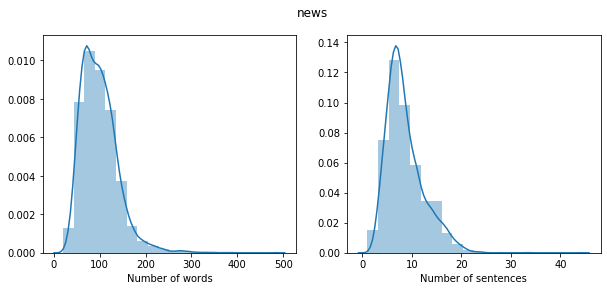

In [16]:
news.show_counts_info()

days
       Number of words  Number of sentences
count       477.000000           477.000000
mean        159.280922            16.020964
std          46.060390             5.171795
min          58.000000             6.000000
25%         126.000000            12.000000
50%         155.000000            15.000000
75%         186.000000            19.000000
max         323.000000            41.000000


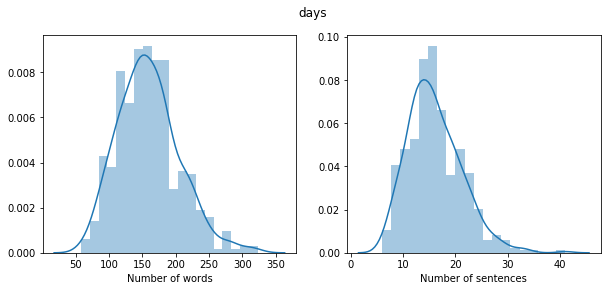

In [17]:
days.show_counts_info()

In [18]:
def draw_boxplots(df, features, filename):
    n_features = len(features)
    n_columns = math.floor(math.sqrt(n_features))
    n_rows = math.ceil(n_features / n_columns)
    fig = plt.figure(figsize=(n_rows * 4, n_columns * 4))

    for n, i in enumerate(features):
        plt.subplot(n_columns, n_rows, n + 1)
        sns.boxplot(x="level", y=i, data=df)

    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

In [19]:
def preprocess_word_list(filename):
    with open(f"wordlists/{filename}", encoding="utf-8") as f:
        words_from_list = f.read().split("\n")

    words_from_list = " ".join(
        [w for w in words_from_list if " " not in w and "-" not in w]
    )
    words_from_list = nlp(words_from_list)
    words_from_list = set(w.lemma_.lower() for w in words_from_list)
    return words_from_list

In [20]:
dct = {}
df = pd.read_csv("wordlists/Vocabulary Framework – British English.csv")
sub_df = df[["Base Word", "Level"]]
sub_df_min = sub_df.groupby("Base Word").min()
for d, data in sub_df_min.reset_index().groupby("Level"):
    dct[d] = list(data["Base Word"])

In [21]:
word2level = {}
for level, words in dct.items():
    for i in range(len(words)):
        if " " not in words[i]:
            word2level[words[i].lower()] = level

In [22]:
levels = ("A1", "A2", "B1", "B2", "C1", "C2")

In [23]:
abstract_nouns = preprocess_word_list("abstract_nouns.txt")
concrete_nouns = preprocess_word_list("concrete_nouns.txt")
print(len(abstract_nouns), len(concrete_nouns))

160 384


In [24]:
news_lexical_df = news.create_lexical_df(abstract_nouns, concrete_nouns)
days_lexical_df = days.create_lexical_df(abstract_nouns, concrete_nouns)

In [25]:
def show_correlations(dataset):
    corr = dataset.corr()
    print(corr["level"].sort_values(ascending=False), "\n")

    features = [f"zipf_freqs_{i}" for i in range(1, 7)] + [
        "type_token_ratio",
        "abstract_nouns",
        "concrete_nouns",
        "A1",
        "A2",
        "B1",
        "B2",
        "C1",
        "C2",
    ]
    draw_boxplots(df=dataset, features=features, filename="vocab.png")

level               1.000000
type_token_ratio    0.440219
B2                  0.416874
C1                  0.278714
zipf_freqs_4        0.270832
B1                  0.265774
zipf_freqs_3        0.239876
C2                  0.215503
zipf_freqs_2        0.145354
abstract_nouns      0.093868
zipf_freqs_1        0.077349
A2                 -0.097981
concrete_nouns     -0.212310
zipf_freqs_5       -0.263046
zipf_freqs_6       -0.457058
A1                 -0.510842
Name: level, dtype: float64 



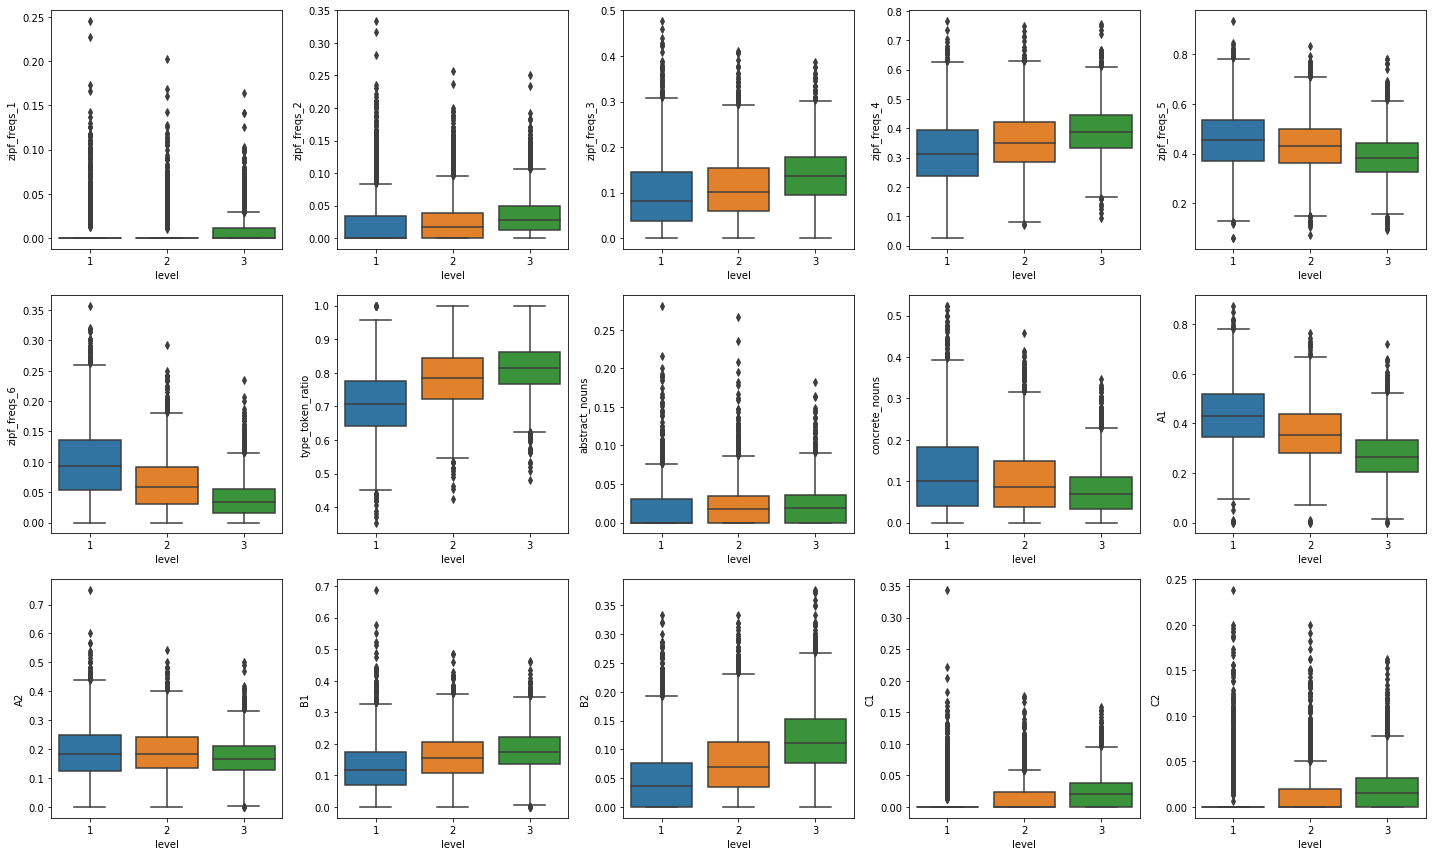

In [26]:
show_correlations(news_lexical_df)

level               1.000000
type_token_ratio    0.644163
B2                  0.474297
zipf_freqs_4        0.355353
B1                  0.348356
C1                  0.228714
zipf_freqs_3        0.188934
abstract_nouns      0.179104
C2                  0.154148
A2                  0.059114
zipf_freqs_2        0.022253
zipf_freqs_1       -0.018042
concrete_nouns     -0.137775
zipf_freqs_5       -0.277141
zipf_freqs_6       -0.462450
A1                 -0.509848
Name: level, dtype: float64 



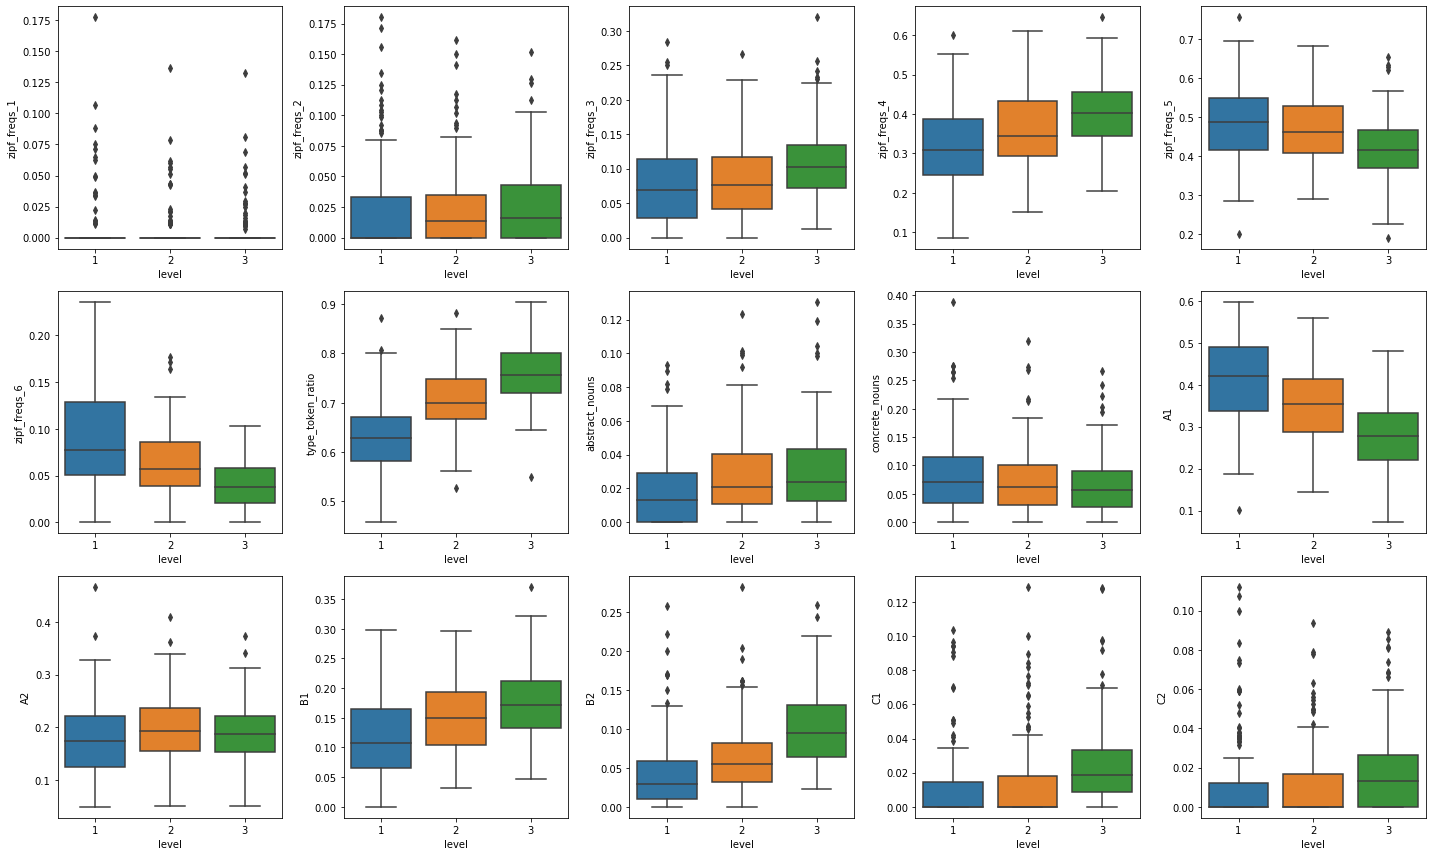

In [27]:
show_correlations(days_lexical_df)